# Prueba ténica Newtral

---


Borja Lozano Álvarez

lozanoalvarez.b@gmail.com

--- 


## Objetivos

* Descarga los datasets en formato CSV de los siguientes enlaces https://ml-coding-test.s3.eu-west-1.amazonaws.com/decibelios_train_data.csv y https://ml-coding-test.s3.eu-west-1.amazonaws.com/decibelios_test_data.csv . Cada fila corresponde a un tweet, su etiqueta y su id.

* Crea un notebook con la solución a las tareas indicadas debajo. Te recomendamos utilizar Google Colab para disponer de recursos de cómputo gratuitos.

* Incluye un análisis descriptivo de los datos. No es necesario que sea muy exhaustivo, céntrate en los aspectos más importantes para el funcionamiento del modelo.

* Crea un modelo de detección de tweets tóxicos utilizando la técnica de fine-tuning de un modelo pre-entrenado de tipo BERT (son válidos cualquier checkpoint de BERT o modificaciones como RoBERTa, XLM, etc). Puedes utilizar librerías y checkpoints como Huggingface Transformers, o cualquier otro a tu elección. 

* El uso de transformers es un requisito mínimo pero puedes realizar pruebas adicionales con cualquier otra arquitectura que consideres que puede funcionar en este caso concreto. Se valorará el trabajo realizado de exploración de soluciones alternativas o propuestas de extensión sobre los propios Transformers.

* Elige cómo plantear el problema. Consideraremos válida tanto A) una solución ternaria (un clasificador que devuelva “0,1,2” o B) una solución binaria (un clasificador que separe entre tweets que son 0 y tweets que son 2). En el escenario binario, si un tweet anotado como 1 es clasificado por el modelo como un 2 debería ser considerado un acierto ‘débil’. El que un 0 sea clasificado como un 2 sí sería considerado, obviamente, un error.

* Puede ampliarse, modificarse o utilizarse cualquier dataset de train que se desee. El dataset de test, sin embargo, siempre debe ser el que hemos proporcionado. No se despreciará ningún registro del dataset de test.

* Puede utilizarse algún tipo de preprocesado previo del texto de considerarse necesario. En caso de utilizarse, explicar el por qué de la elección.

* Evalúa tu solución utilizando el test. Elige las métricas que consideres más adecuadas para el problema y añade un párrafo interpretando tus resultados.

* Realiza un pequeño análisis de errores sobre el conjunto de test. El objetivo de este análisis debería ser identificar si el modelo presenta algún sesgo o el tipo de situaciones en el que suele fallar.

* Utiliza Python>=3.7 y las librerías que desees de computación científica y machine learning del ecosistema Python.

* Comparte tu notebook a través de un repositorio de GitHub público y envíanos el enlace.

In [1]:
!python --version

Python 3.7.15


# Setup

In [ ]:
#@markdown Instalar librerias. Tras ejecutar esta celda el _runtime_ se reiniciará para aplicar los cambios.

!pip install scikit-learn install transformers datasets wandb gradio gdown torch gdown > /dev/null
!pip install -U matplotlib > /dev/null
!wget -nc https://ml-coding-test.s3.eu-west-1.amazonaws.com/decibelios_train_data.csv  https://ml-coding-test.s3.eu-west-1.amazonaws.com/decibelios_test_data.csv > /dev/null
!gdown https://drive.google.com/uc?id=1iZs6v5sWm91Yb3X7ixw9rOkFKcnY7l3E 
import os
os.kill(os.getpid(), 9)

--2022-10-25 10:34:18--  https://ml-coding-test.s3.eu-west-1.amazonaws.com/decibelios_train_data.csv
Resolving ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)... 52.218.93.136, 52.218.0.200, 52.218.62.144, ...
Connecting to ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)|52.218.93.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2738941 (2.6M) [text/csv]
Saving to: ‘decibelios_train_data.csv’

decibelios_train_da 100%[===================>]   2.61M  4.38MB/s    in 0.6s    

2022-10-25 10:34:19 (4.38 MB/s) - ‘decibelios_train_data.csv’ saved [2738941/2738941]

--2022-10-25 10:34:19--  https://ml-coding-test.s3.eu-west-1.amazonaws.com/decibelios_test_data.csv
Reusing existing connection to ml-coding-test.s3.eu-west-1.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 2563781 (2.4M) [text/csv]
Saving to: ‘decibelios_test_data.csv’

decibelios_test_dat 100%[=======

In [3]:
import random
import re
import itertools

import datasets
import torch
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests as r
from IPython.display import display, HTML
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import (
  AutoTokenizer,
  AutoModelForSequenceClassification,
  TrainingArguments,
  Trainer
)

tqdm.pandas()

In [4]:
#@markdown Principales parametros
model_checkpoint="cardiffnlp/twitter-xlm-roberta-base" #@param 

batch_size = 32  #@param [8,16,32]
lr = 2e-5  #@param {type:"number"}
#@markdown Usar los valores <1 para desarrollar y debugear
epochs = 3#@param{type:"slider", min:0.1, max:5, step:0.1}

# Make plots bigger
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 #@param{type:"slider", min:50, max:110, step:10}

device = 0 if torch.cuda.is_available() else -1

#@markdown Si tienes cuenta en wandb puedes usarla para registrar las estadísticas y guardar los modelos
use_wandb = True #@param {type:"boolean"}
project_name="newtral_toxic_tweets" #@param 
%env WANDB_PROJECT=$project_name
report_to = "wandb" if use_wandb else "none"

env: WANDB_PROJECT=newtral_toxic_tweets


In [5]:
args = {
  "evaluation_strategy":"epoch",
  "save_strategy":"epoch",
  "learning_rate":lr,
  "per_device_train_batch_size":batch_size,
  "per_device_eval_batch_size":64,
  "num_train_epochs":epochs,
  "weight_decay":1,
  "load_best_model_at_end":True,
  "save_total_limit":1,
  "report_to":report_to,
  "logging_strategy":"steps",
  "logging_steps":10
}

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/652 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

## Funciones auxiliares

In [6]:
import gc

def clean_gpu():
  """
  Fuerza el colector de basura de python y limpia la cache.

  Tras terminar un entrenamiento es habitual que varios de los tensores con los
  gradientes o el ultimo batch sigan alocados en GPU, pudiendo producirse
  excepciones por CUDA out of memory. 
  """
  gc.collect() 
  torch.cuda.empty_cache()

def end_run():
  """
  Fuerza el colector de basura de python y limpia la cache. Además, si se está
  usando wandb termina el run actual.
  """
  clean_gpu()
  if use_wandb:
    wandb.finish(quiet=True)

def show_random_elements(dataset, num_examples=10):
  """Muestra n_examples aleatorios de un dataset"""
  assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
  picks = []
  for _ in range(num_examples):
    pick = random.randint(0, len(dataset)-1)
    while pick in picks:
      pick = random.randint(0, len(dataset)-1)
    picks.append(pick)
  
  if isinstance(dataset,pd.core.frame.DataFrame):
    df = dataset.iloc[picks]
  else:
    df = pd.DataFrame(dataset[picks])
  display(HTML(df.to_html()))
  

# Data

In [7]:
train = pd.read_csv("decibelios_train_data.csv",index_col=0)
test = pd.read_csv("decibelios_test_data.csv",index_col=0)

# Unimos temporalmente los datasets para su limpieza, exploración y procesamiento
df = pd.concat([train,test],keys=["train", "test"],names=["split", None]).reset_index(level='split')

df.twitterId = df.twitterId.astype(int)

### Limpieza de los datos

Antes de poder explorar los datos es necesario acerciorarnos de que su lectura ha sido correcta y comprobar que no contienen ningún error.

Lo primero que comprobamos es si tenemos en nuestro dataset algun campo vacío.

In [8]:
any(df.isna().sum())

False

Otro error común al crear o cargar datos es la inconsistencía el formato de dichos datos. Por ello comprobaremos que cada variable sea de un único tipo.

In [9]:
df.apply(lambda x: [type(y) for y in x]).value_counts()

split          twitterId      text           label        
<class 'str'>  <class 'int'>  <class 'str'>  <class 'int'>    20000
dtype: int64

En ocasiones podemos encontrar duplicados en el conjunto de datos. Estos duplicados pueden darse de forma natural en numerosos contextos (i.e. dos usuarios publican el mismo tweet) pero en ocasiones puede deberse a un fallo en el procesamiento o en una incorrecta recoleción. En especialmente importante comprobar que ningún dato usado para el entrenamiento esta presente en el conjunto de test, lo que podría super un leakage de información de los datos de test al modelo, compometiendo así su evaluación.

In [10]:
df[df.text.duplicated(keep=False)].sort_values(by="text")

,split,twitterId,text,label
15437,test,1455383757586931712,Bienvenidos a la resistencia ( Azagala 27/6/21...,0
16681,test,1450837076174381056,Bienvenidos a la resistencia ( Azagala 27/6/21...,0
1362,test,1455465446619164672,Cada gesto por pequeño que sea es fundamental ...,0
12361,test,1454076779526860800,Cada gesto por pequeño que sea es fundamental ...,0
8837,test,1456683316241965056,EEUU y la UE anuncian compromiso mundial para ...,0
1338,test,1455846407773069312,EEUU y la UE anuncian compromiso mundial para ...,0
8820,test,1455464963657584640,"La #COP26, una cita crucial para estabilizar ...",0
4226,test,1456684593466195968,"La #COP26, una cita crucial para estabilizar ...",0
9911,test,1454763315918475264,La adaptación al cambio climático es fundament...,0
9290,test,1454470171939287040,La adaptación al cambio climático es fundament...,0


Como podemos observar ambos dataset contienen duplicados. Afortunadamente no hay ningún ejemplo que esté en ambos datasets.

Los duplicados en el dataset de test parecen corresponder a diferentes tweets con el mismo contenido (debído a su diferente _tweetID_). Sin embargo, en el dataset de entenamiento todos los duplicados parecen compartir identificador, por lo que descartaremos dichos duplicados manteniendo la primera ocurrencía.

In [11]:
df.drop_duplicates(inplace=True)

## Exploración de los datos

En esta sección exploraremos los datos para familiarizarnos con ellos y para enteder mejor los posibles procesos o decisiones de diseño a tomar.

### Exploración cualitativa
Antes de proceder a una exploración cuantitativa de los datos es conveniente investigar manualmente algunos ejemplos para familiarizarse con los datos. Esto nos permitira hacer una evaluación cualitativa de los mismos, descubrir posibles errores y contrastar el etiquetado de los ejemplos con nuestra valoración subjetiva. Este último punto puede ser importante en anotaciones subjetivas (como el nivel de decibelios de un tweet). Si nuestro criterio no coincide con el _label_ puede indicar que la relación entre las variables predictoras (el texto en en este caso) y la clase del ejemplo no es consistente entre diferentes anotadores.

In [12]:
for label in df.label.unique():
  show_random_elements(df[df.label==label],5)

,split,twitterId,text,label
13716,train,1272909930958381056,"Oslo-Mérida, analicemos las diferencias en junio, septiembre, octubre,...\n\nLa verdad es que los fiordos extremeños deben ser muy raros porque no se ven glaciares al fondo. Que digo yo que algo tendrá que ver la latitud. Que le pregunte a Carmen Calvo, experta en longitudes. https://t.co/hrXAyzsCVJ",0
19542,test,1402147593732374528,✔️Licenciada en Derecho\n✔️Postgrado en Urbanismo\n✔️Postgrado en Mercados Financieros\n✔️Consultora de reputación empresarial\n✔️20 años de carrera en sector financiero\n\nY te llaman ‘influencer’.\n\nNo sé cómo ha podido pasar. \n\nhttps://t.co/czOEv7FUsN,0
12116,test,1453273710580862976,"Portugal ha vivido un largo período de prosperidad, gracias a los acuerdos entre izquierdas. Hoy, la incapacidad para acordar un presupuesto, puede llevar a adelanto electoral, con riesgo de vuelco a la derecha. Cuando veas las barbas de tu vecino cortar, pon las tuyas a remojar",0
60,train,1271812496299569152,"Dinamarca, Suecia y Finlandia hoy por hoy están bloqueando el fondo de recuperación del que se va a beneficiar España. Son tres gobiernos socialistas. ¿Serán halcones según @el_pais? Ojalá los socialistas españoles sean capaces de convencerles. Me ofrezco a ayudar en lo que pueda",0
1437,train,1233121086331662336,Una de las opciones para ir a Vistalegre desde #Barcelona es el autocar que estamos llenando de valientes patriotas que no se quieren perder el gran acto de #LaAlternativa .\nTodavía estáis a tiempo de reservar vuestra plaza. \n#LaAlternativaYoVoy https://t.co/K8BAD0Iqap,0


,split,twitterId,text,label
2717,test,1461331547840299008,‼️ Para las derechas de este país 🇪🇸 todo lo que hace el Gobierno de Pedro Sánchez está mal.\n\nDa igual que:\n\n✅ EL PLAN DE CHOQUE FRENTE A LA COVID-19 EN APOYO A LA INTERNACIONALIZACIÓN HA MOVILIZADO 2.643 MILLONES DE EUROS\n\n@gpscongreso https://t.co/GXheiNWsC2,1
19728,test,1412819558214340608,Si. Que te maten a patadas mientras te llaman “maricón de mierda” es homofobia y un crimen de odio. \n\n#VoxSenalaOtrosDisparan https://t.co/j02p8FnCU9,1
17988,test,1368910688870149888,"Hoy es un día histórico para la ciencia. Hoy se ha desvelado uno de los misterios más insondables de la humanidad. Hoy por fin conocemos quién estaba detrás del críptico nombre en clave ""M. Rajoy"" en los papeles de Bárcenas. https://t.co/5EiVy5lflX",1
7800,train,1271388603994771712,"Mal día para la derecha de España, se han cargado de un plumazo su argumento político de esta pandemia. La juez ha archivado la causa del 8M. \n\n¿Qué tema sacarán ahora para culpabilizar al gobierno? Tica, tac.....",1
15005,train,1271708880041586688,"“A por ello, mujeres y hombres trans”, de ⁦@MonicaSilvanaG⁩, secretaria de Movimientos Sociales del ⁦@PSOE⁩.\nFrente a burdas manipulaciones y tergiversaciones interesadas, nuestra postura https://t.co/lAafrpfb6N",1


,split,twitterId,text,label
18349,test,1455939067900743680,"#LaAlternativaEsPP \nPablo Casado vapulea los «falsos, radicales, hipócritas y ruinosos» Presupuestos de Sánchez: «Son un bodrio»: https://t.co/HN9CFyGP96",2
12243,train,1261355406296678400,"El objetivo no es machacar Madrid; el objetivo es machacar todo lo que Madrid representa: libertad, impuestos bajos, bonanza económica, y buena gestión política y sanitaria. No podrán con nosotros.",2
5594,train,1255038594512834560,"Nos mienten con el número de test, con el número de fallecidos, con el número de PCR y así con todo.\n\nNo tienen plan e improvisan jugando con nuestras vidas.\n\nPero el que mientes eres tú.\n\n#ElGobiernoDelBulo https://t.co/fOaf6aS3iB",2
7418,train,1277966593339781120,⚖️ @fernandoderosa4 Las voces de las cloacas reclaman una intervención de la Fiscalía Anticorrupción https://t.co/mjZGdQQz3Y vía @ESdiario_com,2
1551,train,1252946281607159808,El PP y Ciudadanos hablan mucho pero muestran su apoyo al Gobierno. Eso es oposición o es sumisión \n#GobiernoFake\n#GobiernoDimisionYa https://t.co/z3zPjYAKDm,2


En algunos ejemplos la linea entre los decibelios suaves y fuertes es bastante difusa. Aunque es comprensible teniendo en cuenta la subjetividad de la anotación es dificil delimilar que se considera "lenguaje violento, belicoso, agresivo o polarizante" de forma objetiva. En menor medida algunos de los ejemplos _no toxicos_ pueden ser percividos como ironía, lo que les daría un ligero nivel de decibelios.

A continuación podemos observar una pequeña recopilación de ejemplos donde, desde mi subjetividad como anotador, discrepo o dudo de la anotación. Es importante remarcar que en ningun caso se pretende hacer un comentario político respecto al mensaje de los tweets, si no destacar que cuando distintos anotadores no coinciden en su criterio puede indicarnos la dificultad intrinseca de los datos para ser diferenciados de forma predictiva.

In [13]:
int_tweets = {
  1273274353703141376: "Si otros tweets que usen un tono de sarcástico están anotados como toxicos es posible que este ejemplo este mal anotado.",
  1456030044019728384: "Basandonos en la definición de _decibelios fuertes_ este tweet debería ser clasificado como tóxico debido al lenguaje violento/agresivo  que usa",
  1425146622716096512: "Aunque el mensaje tiene decibelios podría haber debate sobre el uso de la palabra _siniestra_ o _censura_ como lenguaje violento, belicoso, agresivo o polarizante.",
  1271811134669107200: "Aunque el mensaje tiene decibelios no sabía si clasificarlo como 2 o 1",
  1270977903631704064: "El tweet podría ser polarizante",
  1282817025937674240: "Aunque el mensaje tiene decibelios no sabía si clasificarlo como 2 o 1"
}

df_contraste = df.set_index("twitterId").loc[int_tweets]
df_contraste.loc[int_tweets,"contraste"] = [value for value in int_tweets.values()]

display(df_contraste)

,split,text,label,contraste
twitterId,,,,
1273274353703141376,train,"""Cuando escucho a algunos/as hablar en esta ...",0,Si otros tweets que usen un tono de sarcástico...
1456030044019728384,test,ES QUE VOLVÍA DE FIESTA \n\nLa excusa de los m...,1,Basandonos en la definición de _decibelios fue...
1425146622716096512,train,@Larordana @AmerAcadPeds @SEGMtweets Aquí una ...,2,Aunque el mensaje tiene decibelios podría habe...
1271811134669107200,train,⭕️ La inmigración se dispara un 264% en Andalu...,2,Aunque el mensaje tiene decibelios no sabía si...
1270977903631704064,train,Ábalos oculta el expediente de la adjudicación...,0,El tweet podría ser polarizante
1282817025937674240,train,1. Una jueza sustituta...\nUn auto demencial.....,2,Aunque el mensaje tiene decibelios no sabía si...


Otra observación importante es que hay tweets en distintos idiomas (además de español se ha observado, al menos, gallego). Por falta de tiempo no desarrollaremos este problema pero idealmente podríamos intentar traducir al español u aplicar modelos que hayan sido entrenados con estos idiomas.

###  Tamaño de los datasets y balanceo de clases

El siguiente aspecto a explorar es el numero de ejemplos en nuestro dataset.

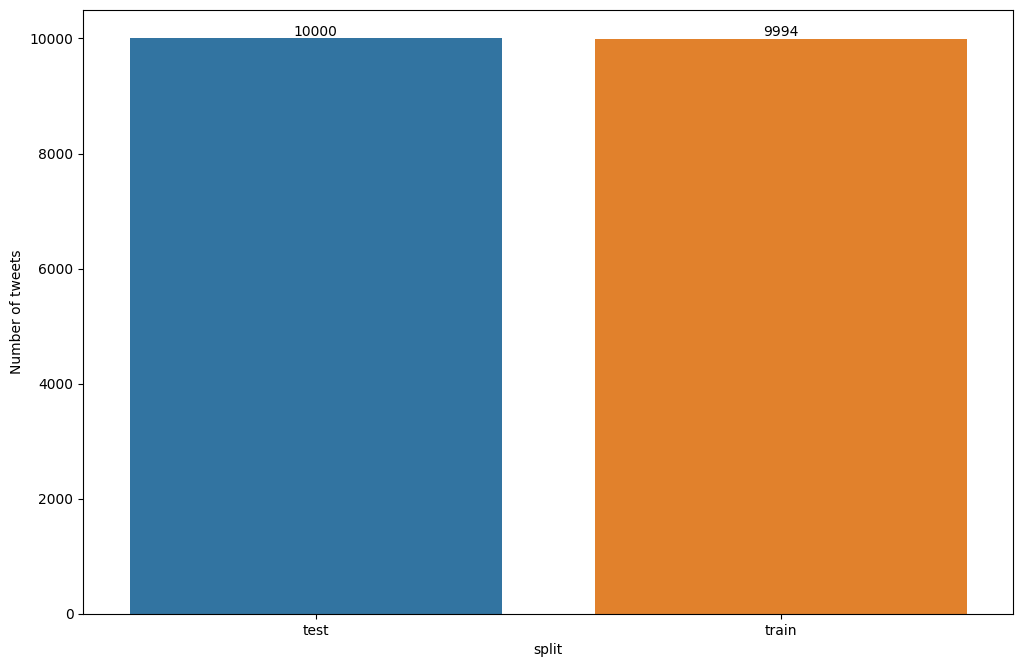

In [14]:
ax = sns.barplot(
  data=df.groupby("split").text.count().rename("Number of tweets").reset_index(),
  x="split",
  y="Number of tweets"
)
ax.bar_label(ax.containers[0]);

Uno de los aspectos mas importantes a considerar al usar datos de entrenamiento es el balanceo de clases, i.e. el porcentaje de ejemplos de cada clase sobre el total del dataset.

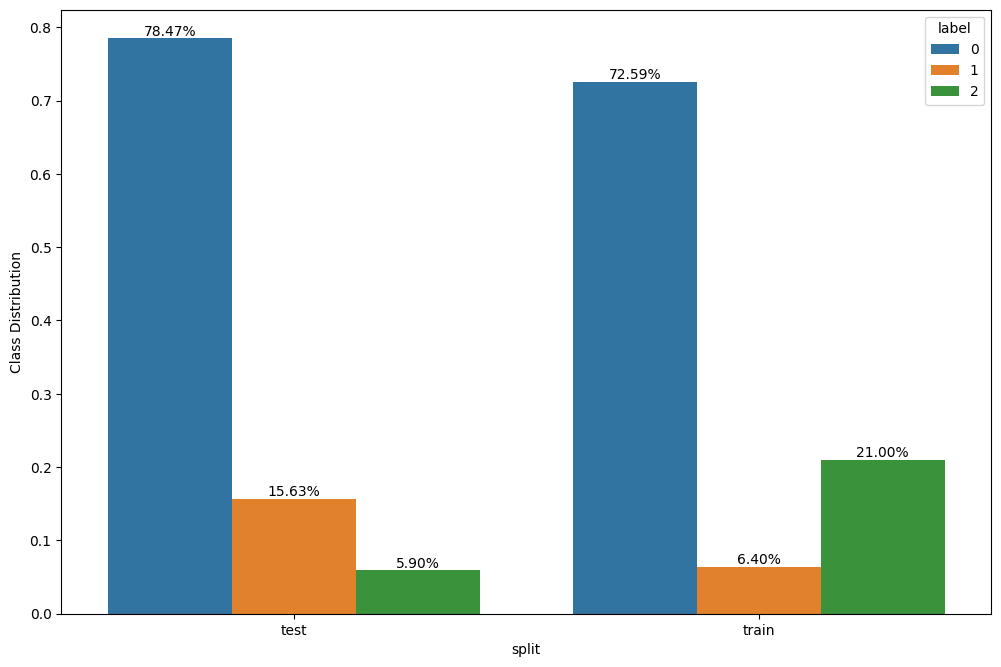

In [15]:
ax = sns.barplot(
  data=df.groupby("split").label.value_counts(normalize=True).rename("Class Distribution").reset_index(),
  x="split",
  y="Class Distribution",
  hue="label"
)
for container in ax.containers:
  ax.bar_label(container, labels=[f'{x*100:,.2f}%' for x in container.datavalues])

Podemos observar un claro desvalance de las clases. Como se ha comentado anteriormente el problema del desbalance de clases puede resultar en clasificadores que aprenden incorrectamente a clasificar en la clase mayoritaria a todos los ejemplos [H. He and E. A. Garcia, 2009].

Otra variable a destacar es el tamaño de los textos. En este caso, al provenir de tweets donde hay un limite de caracteres no deberíamos encontrar un gran desbalance entre clases ni nungún ejemplo especialmente largo.

<AxesSubplot:xlabel='Text Lenght (in number of characters)', ylabel='label'>

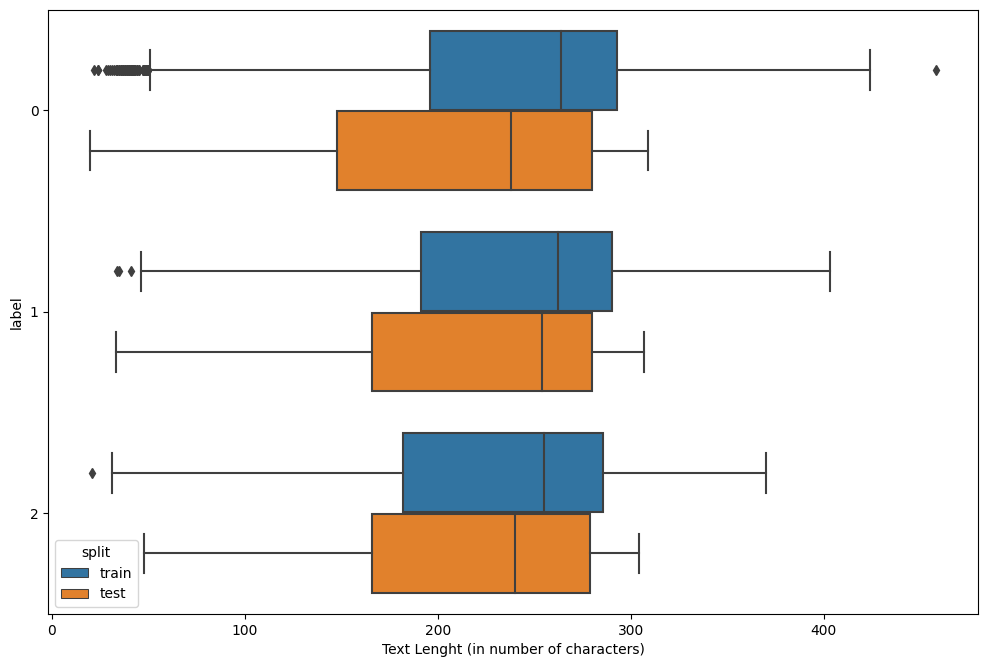

In [16]:
sns.boxplot(
  x=df.text.apply(len).rename("Text Lenght (in number of characters)"),
  y=df.label.astype(str),
  hue=df.split
)

### URLS y menciones
Los tweets pueden contener enlaces a otros usuarios o enlaces a fotos, videos, noticias u otros tweets. Es posible que exista una correlación entre el numero de decibelios y el numero de urls/menciones.

In [17]:
df["urls"] = df.text.apply(lambda x: re.findall(r'(https?://\S+)', x))
df["mentions"] = df.text.apply(lambda x: re.findall(r'\@[^\s]+', x))
show_random_elements(df,5)

,split,twitterId,text,label,urls,mentions
18933,train,1272165670319460352,.@policia @guardiacivil \nEs una estafa que se está recibiendo hoy por SMS https://t.co/pfJAQ1V0Lz,0,[https://t.co/pfJAQ1V0Lz],"[@policia, @guardiacivil]"
18849,train,1516705958914928640,Hoy he inaugurado en el @Congreso_Es la jornada de @ADESyD2011 sobre los 40 años de España en la #OTAN y su papel determinante en la próxima cumbre de Madrid.\n\nEspaña es un país de diálogo pero sin seguridad no hay libertad. Invertir en defensa es invertir en la paz.\n\n@SpainNATO https://t.co/C4ZBqb0Cc7,0,[https://t.co/C4ZBqb0Cc7],"[@Congreso_Es, @ADESyD2011, @SpainNATO]"
16484,train,1313790898195648512,@garciapage “los docentes lo que quieren es 15 días de vacaciones” ¿A quién pretende engañar? ?#PageNoTeCreo https://t.co/OhZ5WDmT3I,2,[https://t.co/OhZ5WDmT3I],[@garciapage]
10395,train,1271140967240937472,¿Cuál es el dato real de fallecidos por #coronavirus en #España?\n#UnCaosDeGobierno\nNubarrones sobre los datos de las muertes por #COVID19 Covid en España\n https://t.co/fI8WrrUvKy https://t.co/x1PidNUelE,2,"[https://t.co/fI8WrrUvKy, https://t.co/x1PidNUelE]",[]
15011,test,1405252501079838720,"Hay que comunicar que el problema de la vivienda no es un fenómeno aislado, que forma parte de un sistema, y que la pinza que está oprimiendo a la población española joven la forman los salarios por los suelos y la vivienda por las nubes\n.@ctxt_es\nhttps://t.co/JjtxMmB64L",0,[https://t.co/JjtxMmB64L],[@ctxt_es]


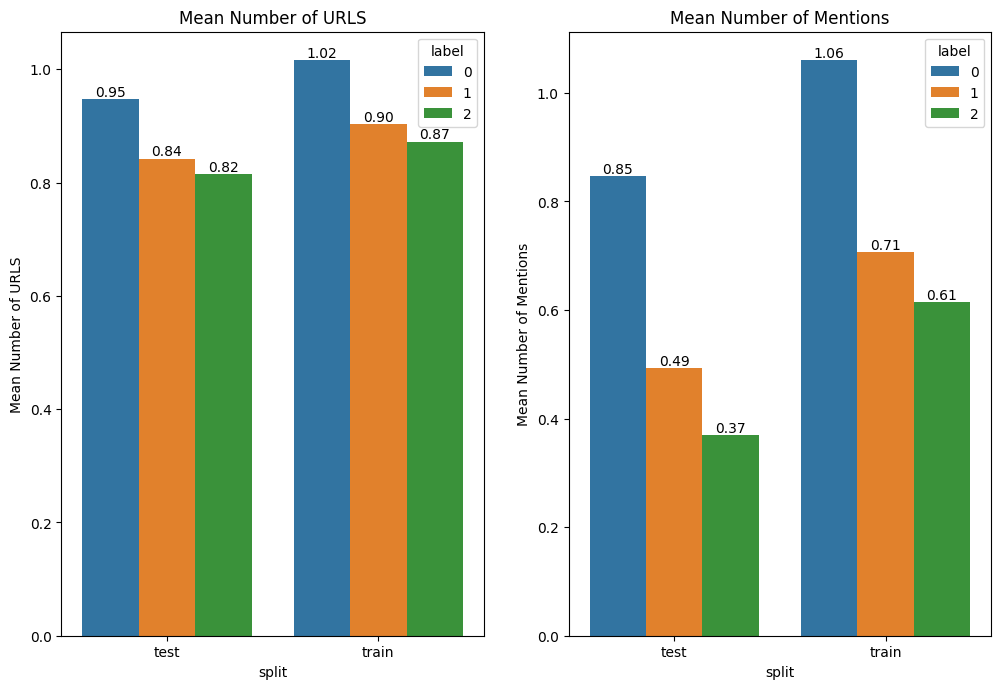

In [18]:
fig, axs = plt.subplots(1, 2)

ax = sns.barplot(
  data=df.groupby(["split","label"]).urls.agg(lambda x: x.apply(len).mean()).rename("Mean Number of URLS").reset_index(),
  x="split",
  y="Mean Number of URLS",
  hue="label",
  ax=axs[0]
)
for container in ax.containers:
  ax.bar_label(container, labels=[f'{x:,.2f}' for x in container.datavalues])
ax.set_title("Mean Number of URLS")


ax = sns.barplot(
  data=df.groupby(["split","label"]).mentions.agg(lambda x: x.apply(len).mean()).rename("Mean Number of Mentions").reset_index(),
  x="split",
  y="Mean Number of Mentions",
  hue="label",
  ax=axs[1]
)
for container in ax.containers:
  ax.bar_label(container, labels=[f'{x:,.2f}' for x in container.datavalues])
ax.set_title("Mean Number of Mentions");


Parece que existe una pequeña relación inversa entre el numero de URLS/menciones y el nivel de decibelios de un tweet.  

## Procesamiento de los datos: Expandiendo las URLS

La mayoría de URLS de los tweets estan acortadas al formato de twitter. Podemos expandirlas para mostrar el dominio completo. Es posible que ciertos dominios se referencien mas en contextos polarizados y esto podría ayudar a la clasificación de nuestro modelo

In [19]:
urls = pd.Series([url for urls in df["urls"] for url in urls]).to_list()

In [20]:
# El modulo request de python es bastante lento pues parsea el contenido del 
# mensaje y cada petición es bloqueante. El tiempo de ejecución para todas las
# URLS supera las 2h. Para optimizarlo paralelizaremos la ejecución y pediremos
# solo el Header de la respuesta pues estamos unicamente interesados en la URL
# completa y no en el contenido de la web en si.

import concurrent.futures
import multiprocessing

session = r.Session()

MAX_THREADS = multiprocessing.cpu_count()
def scrape(url):
  # Algunas URLs pueden no estar bien formadas o quick workaround.  
  try:
    new_url = session.head(url,timeout=1).url
    # print(f"old: {url} - new: {new_url}")
  except:
    new_url = url
  return new_url

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
  new_urls = list(tqdm(executor.map(scrape, urls), total=len(urls)))

url_map = pd.Series(index=urls,data=new_urls).to_dict()

  0%|          | 0/19007 [00:00<?, ?it/s]

In [21]:
def expand_urls(text,urls):
  """Remplaza todas las URLS por su forma extendida"""
  for url in urls:
    text = text.replace(url,url_map[url])
  return text

df.text = df.progress_apply(lambda x: expand_urls(x["text"],x["urls"]) if x["urls"] else x["text"],axis=1)

  0%|          | 0/19994 [00:00<?, ?it/s]

# Modelos

En esta sección exploraremos diferentes modelos para la clasificación de tweet toxicos.

## Métricas

La taréa de clasificación multiclase suele evaluarse con la media de las metricas de clasificación binaria para cada una de las clases. Sin embargo nuestra tarea tiene una peculiaridad, las clases estan **ordenadas**. No es el mismo error considerar un tweet con _decibelios altos_ como _nulo_ que confundir un tweet con _decibelios suaves_ por cualquiera de las otras clases. Para reflejar esta particularidad usaremos también una métrica de regresión, el error medio cuadrado (MSE) para evaluar nuestros modelos.


In [ ]:
from sklearn.metrics import (
  precision_score,
  recall_score,
  f1_score,
  mean_squared_error,
  ConfusionMatrixDisplay,
  classification_report,
  confusion_matrix
)


def report_performance(y_true,y_pred):
  display = ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    normalize="true",
    display_labels=["Nulo","Decibelios suaves", "Decibelios Fuertes"]
  )

  (true_0, false_0_1, false_0_2,
   false_1_0, true_1, false_1_2,
   false_2_0, false_2_1, true_2_2) = display.confusion_matrix.ravel()

  results = {
    "Precision_macro": precision_score(y_true,y_pred,average="macro"),
    "Recall_macro": recall_score(y_true,y_pred,average="macro"),
    "F1_macro": f1_score(y_true,y_pred,average="macro"),
    "MSE" :mean_squared_error(y_true,y_pred),
    "true_0":true_0,
    "false_0_1":false_0_1,
    "false_0_2":false_0_2,
    "false_1_0":false_1_0,
    "true_1":true_1,
    "false_1_2":false_1_2,
    "false_2_0":false_2_0,
    "false_2_1":false_2_1,
    "true_2":true_2_2
  }

  if use_wandb and wandb.run is not None:
    wandb.log({
      f"test/{metric}":score for metric,score in results.items()
  })

  return (results,display)
  

## Baseline

Antes de introducir la exploración de modelos es conveniente definir un modelo lo mas sencillo posible con el que comparar nuestros resultados. Para ello definiremos tres _baselines_:
* _mayority_: Todas los tweets con categorizados con la clase mayoritaria del conjunto de entrenamiento
* _uniform_: Por cada tweet escojemos una clase. La probabilidad de escojer cualquiera de las clases es igual a $\frac{1}{|clases|}$
* _prior_: Por cada tweet escojemos una clase. La probabilidad de escojer cada clase es igual a $\frac{\text{number of tweets from class in train}}{\text{number of tweets in train}}$

In [23]:
all_predictions = {
	"mayority_baseline" : [0]*len(test),
	"uniform_baseline" : np.random.choice(3, len(test)),
	"prior_baseline" : np.random.choice(3, len(test), p=train.label.value_counts(normalize=True).sort_index().values)
}

results = {}
displays = {}


In [24]:
%%capture
for baseline,predictions in all_predictions.items():
  result,disp = report_performance(test.label,predictions)
  results[baseline] = result
  
  displays[baseline] = disp

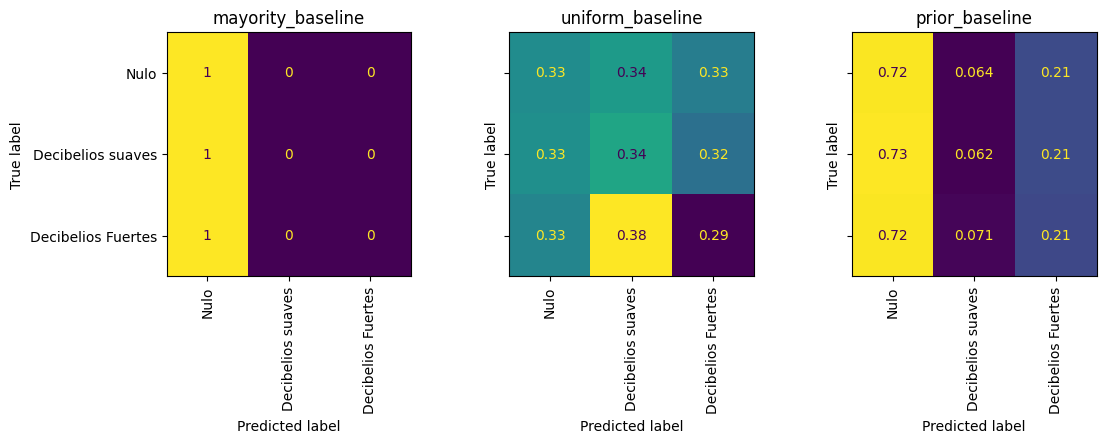

In [68]:
fig, axs = plt.subplots(1, 3, sharey='row')
for ax,(baseline,disp) in zip(axs,displays.items()):
  disp.plot(ax=ax, xticks_rotation=90)
  disp.ax_.set_title(baseline)
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.40, hspace=0.1)

In [26]:
pd.DataFrame(results).T

,Precision_macro,Recall_macro,F1_macro,MSE,true_0,false_0_1,false_0_2,false_1_0,true_1,false_1_2,false_2_0,false_2_1,true_2
mayority_baseline,0.261567,0.333333,0.293121,0.3923,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000
uniform_baseline,0.331247,0.321481,0.257234,1.4979,0.333376,0.338856,0.327769,0.334613,0.34293,0.322457,0.330508,0.381356,0.288136
prior_baseline,0.330796,0.330427,0.309923,1.0412,0.722442,0.064228,0.213330,0.725528,0.06206,0.212412,0.722034,0.071186,0.206780


## Finetune

El modelo que usaremos para fintunear es Twitter-XLM-Roberta-base [Barbieri et.al., 2022]. Es un modelo multilingue entrenado usando 12G de tweets en 100 lenguas entre los que se incluyen los idiomas castellano, catalán y vasco. Este modelo no se ha entrenado de cero si no que inicializa sus pesos usando el modelo XLM-RoBERTa [Conneau et.al, 2019]

Durante nuestra exploración de modelos **no** haremos una exploración de hiperparametros. Los recursos de GPU de google colab son limitados y hay variaciones mas interesantes que cambiar el _learning rate_ o el _batch size_. En concreto probaremos a cambiar la tarea de entrenamiento (i.e. la representación de las labels y la función de perdida con la que entrenamos).

A continuación exponemos las tres approximaciones que usaremos 

### Clasificación Multiclase

En esta solución cada clase se representa como un vector one-hot $y$ donde $y_i=1$, $y_j=0, j\ne1$ si el ejemplo es de la clase $i$. Los logits que el modelo produzca se interpretan como una distribución de probabilidad sobre las clases.

Para atacar al problema del desbalance de clases podemos añadir pesos a la función de perdida de forma que todas las clases tengan el mismo peso en el entrenamiento.

### Regresión
En esta solución la clase se representa como un numero decimal. El modelo produce un solo output para cada ejemplo.

### Regresión Ordinal
La regresión ordinal es la tarea donde se asigna un conjunto de datos a un set de categorías ordenadas. Siguiendo [Cheng, 2007] codificaremos las clases como un vector $y$ de $1-\text{|clases|}$ donde $y_i=1$ si $i$ es menor que la clase.En nuestra tarea la clase 0 se codificaría como [0,0], la clase 1 como [1,0] y la clase 2 como [1,1]. El valor $i$ del vector de logits del modelo se interpreta como la probabilidad sin normalizar. 


### Dataset de desarollo

Para evaluar los modelos usamos un metodo hold-out dividiendo el datasetde entrenamiento en dos splits:

* 70% para el conjunto de entrenamiento con el que haremos el finetune.
* 30% para el conjunto de validación/desarollo con el que poder escoger el mejor checkpoint durante el entrenamiento.

Es importante que al dividir los conjuntos la distribución de cada uno siga siendo similar a la del dataset original. Para ello dividimos de forma estratificada basandos en el número de ejempos de cada clase.

### Detalles de implementación

Para finetunear los modelos usaremos el método ```Trainer``` de la librería [🤗 Huggingface Transformers](https://huggingface.co/docs/transformers/main_classes/trainer). Esta clase es una abstración del proceso de entrenamiento que facilita el desarrollo de los modelos pero esconde gran parte de los detalles técnicos. Entre otras cosas, la clase ```Trainer``` junto al resto del ecosistema de ```transformers``` se encarga por ejemplo, de:
* Alocar los ejemplos y el modelo en el dispositivo adecuado (gpu si esta disponible).
* [Escoger la función](https://github.com/huggingface/transformers/blob/bd469c40659ce76c81f69c7726759d249b4aef49/src/transformers/models/roberta/modeling_roberta.py#L1217) de perdida en base al numero de labels del modelo o al formato de estas.
 * ```MSELoss``` para tareas de regresión
 * ```CrossEntropyLoss``` para clasificación multiclase
 * ```BCEWithLogitsLoss``` para clasificación multilabel o regresión ordinal
* Instanciar el optimizador. Por defecto  ```AdamW```.


In [27]:
from sklearn.model_selection import train_test_split

def split_and_encode(df:pd.DataFrame):
  """Transforma el DataFrame original en tres Datasets tokenizados"""

  train = df[df.split=="train"]
  test = df[df.split=="test"]

  # Split data
  train_text, val_text, train_labels, val_labels = train_test_split(
    train['text'], train['label'], test_size=0.3, random_state=0
  )

  # Data to Huggingface Datasets
  train_dataset = datasets.Dataset.from_dict({'text':train_text,'labels':train_labels})
  dev_dataset = datasets.Dataset.from_dict({'text':val_text,'labels':val_labels})
  test_dataset = datasets.Dataset.from_dict({'text':test.text,'labels':test.label})

  # Group Data
  splits = datasets.DatasetDict({
      'train':train_dataset,
      'dev':dev_dataset,
      'test':test_dataset
  })
  
  # Tokenize
  encoded_dataset = splits.map(lambda example: tokenizer(example['text'],truncation=True), batched=True)

  return encoded_dataset

In [28]:
weights = train.label.value_counts(normalize=True).sort_index().values
weights = 1- torch.tensor(weights).to(torch.float32)
class WeightedTrainer(Trainer):
  """Añade pesos a la función de perdida para clasificación multiclase"""
  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    # We could move the tensor once but it will remain in memory after the
    # training
    loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(logits.device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss


class OrdinalTrainer(Trainer):
  """CrossEntropy Binary loss para clasificación multilabel"""
  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.BCEWithLogitsLoss()
    loss = loss_fct(logits, labels.to(torch.float32))
    return (loss, outputs) if return_outputs else loss

In [42]:
num_labels = {
    "multiclass":3,
    "multiclass_w":3,
    "regression":1,
    "ordinal_regression":2
}

def get_encoded_data(task: str):
  """Transforma las labels en el formato de la tarea y tokeniza el dataset"""
  _df = df.copy()

  if task == "multiclass" or task == "multiclass_w":
    _df.label = _df.label.apply(int)

  elif task == "regression":
    _df.label = _df.label.apply(float)

  elif task == "ordinal_regression":
    _df.label = _df.label.apply(lambda label: [1 if i<label else 0 for i in range(2)])

  encoded_dataset = split_and_encode(_df)
  return encoded_dataset


def get_trainer(task: str):
  """Devuelve el Trainer correspondiente en base a la tarea"""
  if task == "multiclass_w":
    trainer_class = WeightedTrainer

  elif task == "ordinal_regression":
    trainer_class = OrdinalTrainer

  else:
    trainer_class = Trainer
  
  return trainer_class


def decode_predictions(
  predictions:torch.Tensor,
  task:str
):
  """Decodifica las predicciones"""
  y_pred = None

  if task == "multiclass" or task == "multiclass_w":
    y_pred = predictions.argmax(axis=1)

  elif task == "regression":
    y_pred = predictions.squeeze().round().astype(int)

  elif task == "ordinal_regression":
    prob = torch.nn.Sigmoid()(torch.Tensor(predictions))
    y_pred = (prob > 0.5).int().sum(axis=-1)

  return y_pred

def train_and_predict(task: str):
  """Codifica los datos y entrena el modelo y calcula las perdicciones"""
  print(f"Entrenando modelo de {task}")

  print("Codificando los datos")
  encoded_dataset = get_encoded_data(task)
  trainer_class = get_trainer(task)

  model_pretrained = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels[task]
  )
  args["run_name"] = task
  args["output_dir"] = task

  trainer = trainer_class(
    model_pretrained,
    TrainingArguments(**args),
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["dev"],
    tokenizer=tokenizer,
  )

  trainer.train()
  clean_gpu()

  predictions = trainer.predict(encoded_dataset["test"])
  return predictions


In [44]:
for task in ["multiclass","multiclass_w","regression","ordinal_regression"]:
  if task in results:
    continue
  predictions = train_and_predict(task)
  y_pred = decode_predictions(predictions.predictions,task)
  scores,cm = report_performance(test.label,y_pred)
  end_run()
  
  all_predictions[task] = y_pred
  results[task] = scores
  displays[task] = cm

## Resultados

In [45]:
pd.DataFrame(results).T.sort_values(by="F1_macro",ascending=False).style.background_gradient(axis=0, low=0, high=0.5) 

,Precision_macro,Recall_macro,F1_macro,MSE,true_0,false_0_1,false_0_2,false_1_0,true_1,false_1_2,false_2_0,false_2_1,true_2
regression,0.563416,0.626847,0.565180,0.286200,0.920861,0.049191,0.029948,0.474088,0.215611,0.310301,0.089831,0.166102,0.744068
ordinal_regression,0.547779,0.626225,0.546215,0.319600,0.912833,0.046387,0.040780,0.456814,0.186180,0.357006,0.084746,0.135593,0.779661
multiclass_w,0.496896,0.625998,0.476300,0.491000,0.864662,0.037467,0.097872,0.340371,0.094690,0.564939,0.045763,0.035593,0.918644
multiclass,0.390352,0.607816,0.442604,0.425100,0.921754,0.000000,0.078246,0.479207,0.000000,0.520793,0.098305,0.000000,0.901695
prior_baseline,0.330796,0.330427,0.309923,1.041200,0.722442,0.064228,0.213330,0.725528,0.062060,0.212412,0.722034,0.071186,0.206780
mayority_baseline,0.261567,0.333333,0.293121,0.392300,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
uniform_baseline,0.331247,0.321481,0.257234,1.497900,0.333376,0.338856,0.327769,0.334613,0.342930,0.322457,0.330508,0.381356,0.288136


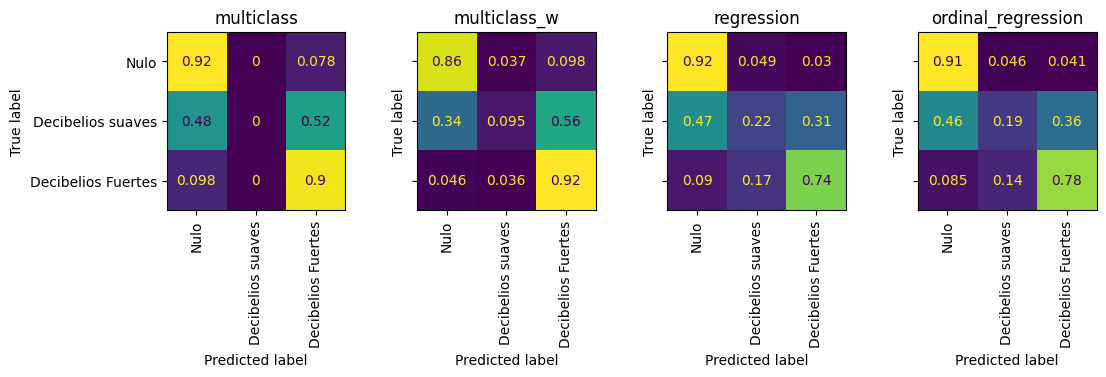

In [58]:
fig, axs = plt.subplots(1, 4, sharey='row')
axs = axs.ravel()
for ax,run in zip(axs,["multiclass","multiclass_w","regression","ordinal_regression"]):
  disp = displays[run]
  disp.plot(ax=ax, xticks_rotation=90)
  disp.ax_.set_title(run)
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.4)

In [32]:
pd.DataFrame(results).to_csv("results.csv")

Como podemos observar los dos modelos donde el orden juega un papel en la codificación de las clases (regresión y regresión ordinal) obtienen con diferencia los mejores resultados, tanto en _F1_macro_ como en _MSE_. Sin embargo los modelos de clasificación son mas precisos a la hora de identificar correctamente los ejemplos de las clases 0 y 2. Es interesante destacar el bajo porcentaje de fallos entre las clases 0 y 2. Sin embargo, todos los modelos tienen problemas a la hora de diferenciar entre la clase 1 y las demás. Este era uno de los problemas esperados que encontramos tras la exploración cualitativa de los datos.

El modelo de regresión es el que mejor resultados obtiene por lo que escogeremos para el análisis de errores.  

Puede explorar las graficas de perdida respecto al tiempo asi como la evolución de otras variables en [wandb](https://wandb.ai/blozano/newtral_toxic_tweets?workspace=user-blozano)

# Análisis

En esta sección analizaremos los errores mas característicos que comete el modelo.

In [153]:
results_df = pd.read_csv("predictions.csv",index_col=0)[["twitterId","text","label","regression"]]
results_df.twitterId = results_df.twitterId.astype(int)

In [166]:
reference_tweets = [
    1355603505365585920,
    1449350338667032576,
    1376992592555094016,
    1352934915407552512,
    1387437703096983552,
    1363237757842313216,
    1364233997354733568,
    1403345824931889152
]

display(results_df.set_index("twitterId").loc[reference_tweets])

,text,label,regression
twitterId,,,
1355603505365585920,Hace 23 años ETA mató en Sevilla al concejal A...,0,2
1449350338667032576,Viejos rockeros que seguimos dando guerra a fa...,0,2
1376992592555094016,“Es más patriota ser de centro que ser de uno ...,0,2
1352934915407552512,"👼🏼 ""Ya es hora de que la basura empiece a flui...",0,2
1387437703096983552,Si todavía no habéis oído el chotis que ha hec...,0,2
1363237757842313216,Marlaska @interiorgob es el máximo responsable...,2,0
1364233997354733568,En lugar de responder a los argumentos de VOX ...,2,0
1403345824931889152,Es viernes y Marlaska cumple….sigue en Moncloa...,2,0


### Errores Graves

Consideramos error grave cuando la distancia entre la clase real y la predicha es mayor a 1, es decir, cuando un tweet con nivel de decibelios _nulo_ se clasifica como _fuerte_ y viceversa. Hay un total de 288 errores graves. 

In [165]:
ind_0_2 = (results_df.label==0) & (results_df.regression==2)
ind_2_0 = (results_df.label==2) & (results_df.regression==0)
show_random_elements(results_df[ind_0_2],5)
show_random_elements(results_df[ind_2_0],5)

,twitterId,text,label,regression
12339,1369550364589101056,"Del compromiso y su fuerza transformadora. Pero👇🏽\n\n“Se está produciendo la “gran regresión”: el retorno a las democracias oligárquicas, plutocráticas, en forma de una norteamericanización de la vida pública.”\n\nPor ⁦@ManoloMonereo⁩\nNo dejen de leerlo https://t.co/lIaWrZmhXw",0,2
15543,1451463216534638592,"Alberto Rodríguez fue condenado sin pruebas por un delito que no cometió. Ahora le quieren quitar el acta que le dieron 65.000 canari@s cuando NO pone eso en la sentencia. Si se consuma esta aberración jurídica, España volverá a hacer el ridículo en Europa.\n\nAquí lo explico 👇🏼 https://t.co/lN69tp5IH7",0,2
16093,1465047726672986112,"Policías manifestándose contra la democracia, contra el poder legislativo.\nPolicías manifestándose contra el Gobierno.\nPolicías que deben dejar de ser policías. \nSon una amenaza a la democracia, no sirven a España ni a su ciudadanía se sirven a ellos y su ideología.",0,2
16345,1363093899183554560,"Romper escaparates y quemar contenedores no es mejorar la democracia\n\nY esto no es libertad de expresión:\n\n“¡Merece que explote el coche de Patxi López!\n¡Que alguien clave un piolet en la cabeza de José Bono!\nNo me da pena tu tiro en la nuca, socialisto.\nOjalá vuelvan los GRAPO.”",0,2
16339,1453415098006097920,Casado miente: el PP se abstuvo en el segundo estado de alarma https://t.co/0Ry4JGIWtS,0,2


,twitterId,text,label,regression
15941,1453703145754857472,Desinformación climática: del negacionismo al fatalismo y el ecopostureo https://t.co/UNLMHask2N,2,0
4426,1401814446515888128,"La corrupción del #PP le acompaña desde el Pasado, el #PP es sinónimo de corrupción, en el pasado y también en el presente de la época #Casado. Génova, Cospedal... https://t.co/8Zu7YeNWf9",2,0
7385,1400526867371855872,¡China debe pagar! https://t.co/ruibBcyXDt a través de @YouTube,2,0
8233,1403345824931889152,"Es viernes y Marlaska cumple….sigue en Moncloa gracias a los 5 votos de BILDU a cambio de cada viernes acercar 5 asesinos de ETA,al País Vasco!! #marlaskadimisión \n\nPrisiones acerca a otros cuatro presos de ETA: dos de ellos, condenados por asesinato https://t.co/7aiXm2f3Ol",2,0
2742,1425063522325696512,"¿Y no será que los incendios de los bosques son debidos a que, como pasa en Segovia, la secta ecologista ordena que no se limpie la maleza y no se retire las ramas secas? ¿No será que la culpa la tengan los verdes rojo fuego?",2,0


Como se destacó en la exploración de datos, hay errores que parecen deberse a la subjetividad de la anotación. Dependiendo de que entendamos por polarizante, muchos tweets, como el 1387437703096983552, podrian considerar que elevan los decibelios del discurso por el simple hecho de incluir temas delicados o que polarizan a varios sectores de la población

Parece que hay ciertas palabras que activan al modelo a predecir una nivel de decibelios alto. Tweets como el 1355603505365585920 o el 1449350338667032576 contienen palabras muy polarizantes como _ETA_, _bandos_ o _Guerra_ usadas generalmente en contextos muy polarizantes.  

### Errores Leves. 

Consideramos ahora que errores comete el modelo al clasificar incorrectamente los tweets con errores leves. Nos centraremos especialmente en los tweets con pocos decibelios mal clasificados (la mayoría de ellos clasificados en una de las clases restantes)

In [158]:
ind_1_0 = (results_df.label==1) & (results_df.regression==0)
ind_1_2 = (results_df.label==1) & (results_df.regression==2)
show_random_elements(results_df[ind_1_0],5)
show_random_elements(results_df[ind_1_2],5)

,twitterId,text,label,regression
7601,1407695782506078208,"En la Comisión de Igualdad, Podemos nos hace el honor a las mujeres de concedernos el derecho a practicar la lactancia materna o artificial. ¿En qué mundo viven?\n\nYo he dado el pecho a mis hijos 2 años porque me ha dado la gana, no porq las feministas me lo permitan. \nYo decido.",1,0
1787,1456200575918485504,"Iniciamos la segunda sesión de debate de #PGE2022 , unos presupuestos que solo se pueden definir como #PGEdelaRuina y ante los que hemos presentado enmienda a la totalidad. https://t.co/Y8cU9SodRu",1,0
9309,1349443288764448768,"El #PSCIrresponsable dice que no está justificado un aplazamiento de las elecciones en Cataluña.\n\n¿2.400 hospitalizados por COVID no es suficiente?\n¿O 41% de las UCI ocupadas por contagiados?\n¿O una incidencia superior a la nacional?\n\nEs momento de salvar vidas, no elecciones. https://t.co/nwrJQXUBnH",1,0
17778,1386253541082341376,"Hoy vuelve a ir de democracia o fascismo, de libertad o fascismo. \n\nDe privilegiar a pocos o garantizar a todxs las condiciones materiales de la libertad.\n\nDe vivir juntxs, libres del miedo, con vivienda, sanidad, educación, en una tierra de fraternidad\n\n#25abrilsempre https://t.co/j7oWbPA03n",1,0
13641,1390961729538990080,"El País Vasco pide un toque de queda ""voluntario"" O sea que tu toques la trompeta. https://t.co/1X59wk0ZWL vía @libertaddigital",1,0


,twitterId,text,label,regression
8066,1369214684965003264,"Celebro el triunfo de la democracia y del Estado de Derecho en Europa con la retirada de la inmunidad a los diputados fugados de la justicia.\n\nEs indignante el voto de Podemos, partido dentro del Gobierno de España, a favor de los que denuestan a España. https://t.co/JwDkx31N82",1,2
14017,1407048287601967104,"El Consejo de Europa, otro golpista ¡Todos a Colón a pedir la autarquía! https://t.co/8ipYOXO7y9",1,2
17630,1385716588742066176,El odio contra Pablo Iglesias y Unidas Podemos no se ha fabricado solo https://t.co/hUzeUXZ51Y,1,2
11395,1451869477633671168,".@Yolanda_Diaz_: ""Vamos a derogar la reforma laboral a pesar de todas las resistencias.""\n\nEsta firmeza para defender los derechos de la gente trabajadora es precisamente lo que explica que nos persigan, nos acosen, nos difamen y nos roben ilegalmente escaños. Esto y no otra cosa. https://t.co/GvXIrHisBK",1,2
6606,1415412513001328640,@Vox_Cantabria culpa a Quiñones de que cada fin de semana acudan bandas de menas a Cantabria para agredir y robar a adolescentes. #SoloQuedaVox \n\n https://t.co/lVAvzjFN2H,1,2


Como se comprobará de forma mas cuantitativa en la siguiente sección, hay atisbos de cierto sesgo politico del modelo. Por lo general parece que el modelo tiende a subestimar el nivel de decibelios presentes en los tweets donde se habla del partido socialista mientras que la mención a partidos mas polarizantes como Podemos o VOX tiene a sumar decibelios al tweet. 

La mayoría de tweets de la clase 1 tienden a ser claramente polarizantes, pero dado el poco numero de ejemplos en la clase de entrenamiento y su similaridad con el lenguaje de tweets de otras clases hace dificil la correcta identificación de los mismos. 

### Análisis Político
Existe la posiblidad de que el modelo tenga cierto sesgo respecto a partidos políticos, confundiendo su nivel de decibelios en base a la polaridad media de sus tweets. Como aproximación simple para descubrir dicho sesgo vamos a explorar los ratios de errores en tweets donde aparezcan keywords representativas de cada partido.

In [142]:
keywords = {
    "PP": ["pp","partido popular","ayuso","casado"],
    "PSOE": ["psoe","socialista","sanchez"],
    "PODEMOS": ["podemos","iglesias","yolanda"],
    "VOX": ["vox","abascal","espinosa"]
}

errores_graves = abs(results_df.label-results_df.regression)==2
errores_leves = abs(results_df.label-results_df.regression)==1

sesgo_partidos = dict()

for partido, palabras in keywords.items():
  key_in_tweet = results_df.text.apply(lambda x: any(key in x.lower() for key in palabras))

  n_tweets = len(results_df[key_in_tweet])
  n_errores_leves = len(results_df[key_in_tweet & errores_leves])
  n_errores_graves = len(results_df[key_in_tweet & errores_graves])

  sesgo_partidos[partido] = {
      "tweets": n_tweets,
      "errores_leves": n_errores_leves,
      "errores_graves": n_errores_graves,
      "ratio_leves": n_errores_leves/n_tweets,
      "ratio_graves": n_errores_graves/n_tweets,
  }

sesgo_partidos = pd.DataFrame(sesgo_partidos).T

  

,tweets,errores_leves,errores_graves,ratio_leves,ratio_graves
PODEMOS,536.000000,145.000000,23.000000,0.270522,0.042910
VOX,711.000000,235.000000,30.000000,0.330520,0.042194
PP,1316.000000,329.000000,49.000000,0.250000,0.037234
PSOE,1123.000000,205.000000,33.000000,0.182547,0.029386


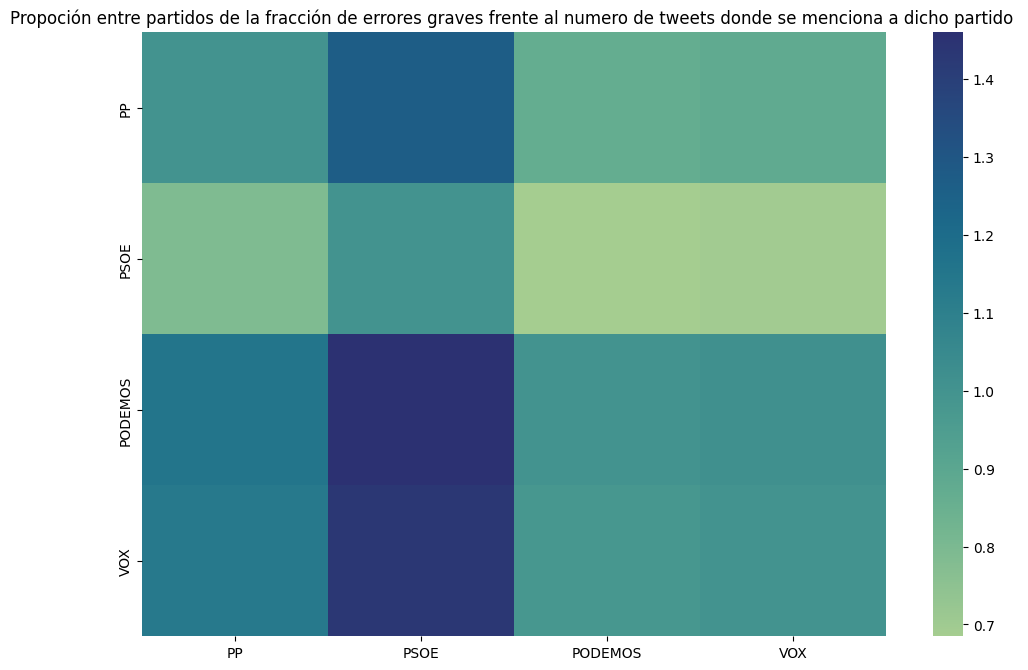

In [143]:
compare_ratios = np.zeros((4,4))
ratio_grave = sesgo_partidos.ratio_graves.to_dict()
for i, (_,ratio_i) in enumerate(ratio_grave.items()):
  for j, (_,ratio_j) in enumerate(ratio_grave.items()):
    compare_ratios[i,j] = ratio_i/ratio_j

ax = sns.heatmap(compare_ratios,yticklabels=ratio_grave,xticklabels=ratio_grave,cmap="crest")
ax.set_title("Propoción entre partidos de la fracción de errores graves frente al numero de tweets donde se menciona a dicho partido ")
sesgo_partidos.sort_values(by="ratio_graves",ascending=False).style.background_gradient(axis=0) 

Text(0.5, 1.0, 'Propoción entre partidos de la fracción de errores leves frente al numero de tweets donde se menciona a dicho partido ')

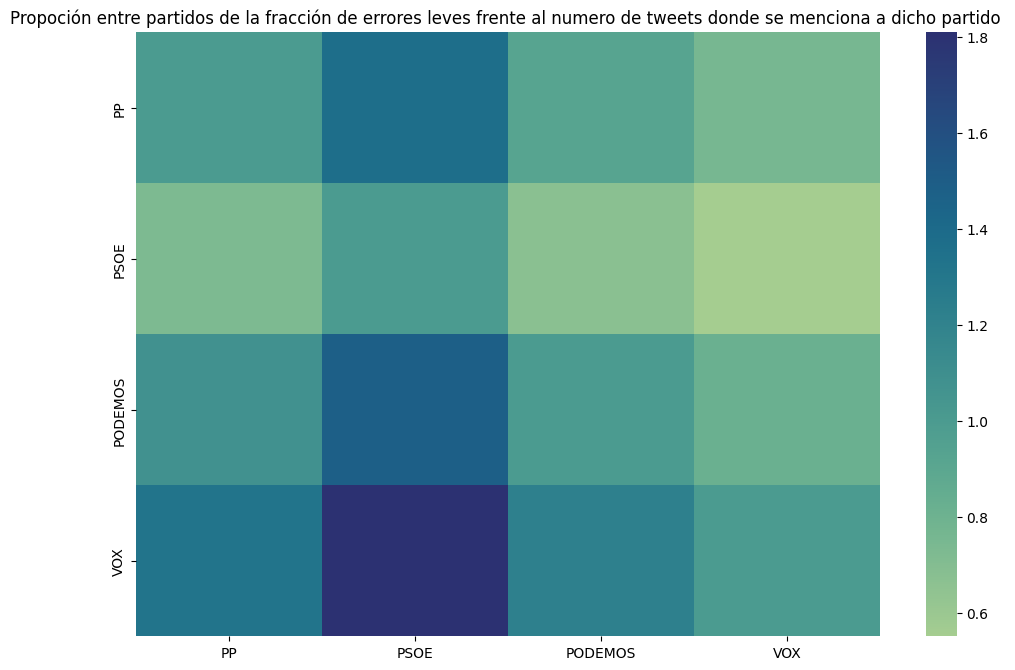

In [145]:
compare_ratios = np.zeros((4,4))
ratio_leve = sesgo_partidos.ratio_leves.to_dict()
for i, (_,ratio_i) in enumerate(ratio_leve.items()):
  for j, (_,ratio_j) in enumerate(ratio_leve.items()):
    compare_ratios[i,j] = ratio_i/ratio_j

ax = sns.heatmap(compare_ratios,yticklabels=ratio_leve,xticklabels=ratio_leve,cmap="crest")
ax.set_title("Propoción entre partidos de la fracción de errores leves frente al numero de tweets donde se menciona a dicho partido ")

Basandonos en la anterior aproximación (la cual es incompleta y debería perfeccionarse) el modelo tiene cierto sesgo con los partidos mas alejados del centro político. Esto puede deberse a un sesgo en la anotación, a un cambio de la distribución del conjunto de test frente al de entrenamiento o, como ya mencionamos anteriormente, a que algunos partidos tienden a ser mas polarizantes que el resto.

El modelo parece que tiende a subestimar el nivel de decibelios en tweets del Partido Socialista. Mas haya de la exploración realizada tweets como el 1363237757842313216,1403345824931889152 o el 1364233997354733568 son una clara muesta de este ejemplo.

Si quisieramos eliminar este sesgo podríamos sustituir las palabras que relacionan los tweets con un partido por tokens mas genéricos. 

# Conclusiones y siguientes pasos

La toxicidad de un mensaje es una valoración subjetiva del mismo. En muchos casos resulta evidente para una población el ponerle dicha etiqueta a un discurso concreto, ya sea por el tema o el lenguaje usado. Pero la frontera entre el nivel de toxicidad no es tan clara. Como posibilidad para desdibujarla sería necesario la anotación por un grupo diverso de individuos de los mismos tweets, pudiendo usar como nivel de toxicidad la media de las anotaciones, poderarlos por el ratio kappa de Cohen o simplemente descartando tweets donde no hay un claro consenso.

A nivel tecnico existen varias tecnicas interesantes que podrían aplicarse. Existe la posibilidad de que la toxicidad de un tweet vaya ligada no solo a texto. El nivel de decibelios puede subir mediante el uso de imagenes o videos polarizantes, menciones a personajes controvertidos o link a medios poco fiables. A nivel texto es posible que el algoritmo se beneficie de un mayor volumen de datos (pudiendo añadir [ejemplos en otros idiomas](https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset) aprovechando las capacidades multilingues de los sistemas XLM) o aplicando tecnicas de entrenamiento en [multiples tareas](https://arxiv.org/pdf/2005.00247.pdf) donde puede haber una trasferencia de conocimientos.